## 밑바닥부터 시작하는 딥러닝(Deep Learning from Scratch) 챕터별 예제코드 정리 
예제코드가 기본이나 정확히 일치하지는 않습니다. 개인적으로 모든 코드들을 문서화하되 너무 기본적인 내용은 제외하거나 나름대로 더 필요하다고 생각되는 내용은 추가하였습니다. 같은 내용을 다른 방식으로 구현하는 경우도 있습니다.
## Chapter 5. 오차역전파법 (Error-backpropagation)

### Softmax, Cross-entropy-error 구현
Back-propagation으로 analytic gradient를 계산, parameter를 gradient descent로 학습하는 neuralnet을 구현하기위해서 사전에 필요한 function을 두 가지 구현

In [1]:
## prerequisite
import numpy as np
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T
    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size

### 5.5  활성화 함수 (Activation function) 계층 구현
### Relu (Rectified Linear Unit)

In [2]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        return dx

### Sigmoid 

In [3]:
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = (1 - self.dout) * self.out * dout
        return dx

### 5.6 Affine / Softmax 계층 구현
### Affine 계층

In [4]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis = 0)
        return dx

### Softmax-with-Loss 계층

In [5]:
# Softmax with cross entropy loss
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # softmax의 출력
        self.t = None # 정답 레이블 (one-hot representation)

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss

    def backward(self, dout = 1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        return dx

### 5.7 Train a neuralnet with Back-propagation for Mnist data
    structure = (784, 50, 10)
    batch_size = 100
    learning_rate = 0.1
    iter = 10000

### Generate TwoLayerNet class 

In [6]:
## generate TwoLayerNet class
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
   #     self.layers['Relu2'] = Relu()
        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis = 1)

        if t.ndim != 1:
            t = np.argmax(t, axis = 1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def gradient(self, x, t):

        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()

        for layer in layers:
            dout = layer.backward(dout)

        # parameter 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        return grads

### Load Mnist dataset

In [7]:
# mnist dataset load
import sys, os
import pickle
import time
import matplotlib.pylab as plt
os.chdir('C:\\Users\\KBS\\PycharmProjects\\Deep_learning_scratch')
from dataset.mnist import load_mnist
(x_train, t_train), (x_test, t_test) = load_mnist(normalize = True, one_hot_label = True)

### hyper-parameter setting

In [8]:
# hyper-parameter setting
iters_num = 10**4
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1
iter_per_epoch = max(train_size / batch_size, 1)

# save loss
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
epoch = -1

### Training
실제로 아래의 코드 블록을 실행시키면 학습이 진행됨, 실제로 이 notebook에서는 학습은 시키지는 않고 아래의 코드블록으로 학습된 parameter를 load하여 loss의 변화를 관찰

In [9]:
# network = TwoLayerNet(input_size = 784, hidden_size = 50, output_size = 10, weight_init_std = 0.01)
# for i in range(iters_num):
#     # sample mini-batch
#     batch_mask = np.random.choice(train_size, batch_size)
#     x_batch = x_train[batch_mask]
#     t_batch = t_train[batch_mask]
#
#     # calculate gradient (with backprop)
#     grad = network.gradient(x_batch, t_batch)
# 
#     for key in ('W1', 'b1', 'W2', 'b2'):
#         network.params[key] -= learning_rate * grad[key]
# 
#     train_loss = network.loss(x_batch, t_batch)
#     val_loss = network.loss(x_test, t_test)
#     train_loss_list.append(train_loss)
#     val_loss_list.append(val_loss)
#
#     if i % 20 == 0:
#         print('epoch = ', epoch, 'iter = ', i, 'train_loss = ', train_loss, 'val_loss = ', val_loss)
# 
#     if i % iter_per_epoch == 0:
#         epoch += 1
#         train_acc = network.accuracy(x_train, t_train)
#         train_acc_list.append(train_acc)
#         val_acc = network.accuracy(x_test, t_test)
#         val_acc_list.append(val_acc)

In [10]:
# 학습된 weight와 bias를 load
import pickle
f = open('C:/Users/KBS/PycharmProjects/Deep_learning_scratch/DLFS_5_2.pkl', 'rb')
network = pickle.load(f)
f.close()

In [11]:
# network의 loss를 load
f = open('C:/Users/KBS/PycharmProjects/Deep_learning_scratch/DLFS_5_2_loss_acc.pkl', 'rb')
train_loss_list, val_loss_list, train_acc_list, val_acc_list = pickle.load(f)
f.close()

### Visualization for loss 

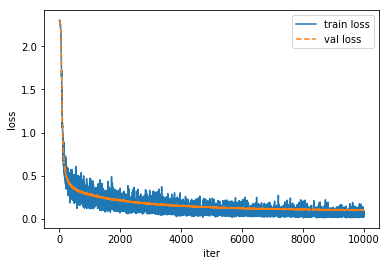

In [12]:
import matplotlib.pylab as plt
%matplotlib inline
# loss
x = np.arange(len(train_loss_list))
plt.plot(x,train_loss_list, label = 'train loss')
plt.plot(x,val_loss_list, label = 'val loss',linestyle = '--')
plt.xlabel('iter')
plt.ylabel('loss')
plt.legend(loc = 'upper right')
plt.show()

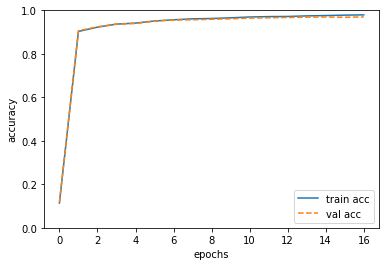

In [13]:
# accuracy
markers = {'train': 'o', 'val': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, val_acc_list, label='val acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()